# LGBM Tuning ver2
* **[val] 33.4 / [test] 32.8**
* Bayesian Optimization 
* SHAP visualization : 아래에 해석을 좀 달아 두었습니당 ~ 

In [4]:
import os
import sys
import joblib
import pickle as pkl

import warnings
warnings.filterwarnings(action='ignore')

import pandas as pd 
import numpy as np

from IPython.display import display
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option('display.max_info_columns', 500)

import datetime
from tqdm import tqdm

In [2]:
# visualize
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
plt.rc('font', family='NanumBarunGothic')
plt.rc('axes', unicode_minus=False)

# Data Load
* embedding ver4 (90 dim)

In [5]:
cd /content/drive/My Drive/쇼핑광고등어

/content/drive/My Drive/쇼핑광고등어


In [6]:
data_v4 = joblib.load(os.path.join('1. Data', '05_분석데이터', '5th_FE_ver4.pkl'))
locals().update(data_v4)

In [7]:
X = data_v4['X'] ; y = data_v4['y']
X = X.drop(["log최근3개월상품군추세"], axis=1)
X.shape, y.shape

((35379, 333), (35379,))

In [8]:
# log(y)
y2 = np.log1p(y)

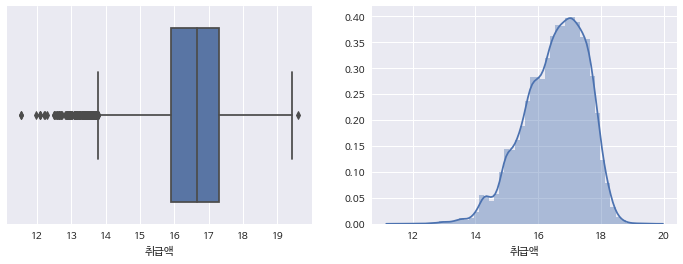

In [9]:
figure, (ax1, ax2) = plt.subplots(ncols=2)
figure.set_size_inches(12,4)

sns.boxplot(y2, ax=ax1)
sns.distplot(y2, ax=ax2)

# Modeling 
* cv = 5, epoch = 25000, early = 500, random_state=77

In [10]:
def MAPE_exp(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((np.exp(y_true) - np.exp(y_pred)) / np.exp(y_true))) * 100

In [ ]:
# !pip install bayesian-optimization

In [ ]:
# !pip install shap

In [13]:
import lightgbm as lgb

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from bayes_opt import BayesianOptimization

import shap

In [ ]:
# val / test MAPE 31 
lgbm_params4 = {'num_leaves': 47, 'max_depth': 8, 'min_child_samples': 39, 
                'learning_rate': 0.019268151551455108, 'reg_lambda': 0.2959823312094688, 'min_split_gain': 0.01022963196332564, 
                'colsample_bytree': 0.7957384348169647, 'subsample': 0.8124183802143509, 'subsample_freq': 5, 'max_bin': 56, 
                'boosting': 'dart', 'objective': 'regression', 'metric': 'mape', 'is_training_metric': True, 'n_estimators' : 15000}

In [19]:
params_range = {
                'num_leaves': (32, 64),
                'max_depth': (8, 32),
                'min_child_samples': (30, 50),  
                'reg_lambda': (0.2, 0.4), 
                'min_split_gain': (0.005, 0.025),
                'colsample_bytree': (0.7, 0.9), 
                'subsample': (0.75, 0.85), 
                'subsample_freq': (4, 6),
                'max_bin': (45, 70), 
                'learning_rate' : (.005, .02)
               }

## Bayesian Optimization 
* 스케일링 까먹고 안해따...^^;;; 허허 

In [33]:
def Bayes_running(num_leaves, max_depth, min_child_samples, reg_lambda, min_split_gain, colsample_bytree, subsample, subsample_freq, max_bin, learning_rate):
    params = { 
                'boosting': 'gbdt', 'objective': 'regression', 'metric': 'mape', 'is_training_metric': True, 'n_estimators' : 25000, 
              
                "num_leaves": int(round(num_leaves)),
                "max_depth" : int(round(max_depth)),
                'min_child_samples': int(round(min_child_samples)), 
                'reg_lambda': max(reg_lambda, 0), 
                "min_split_gain": min_split_gain,
                'colsample_bytree': colsample_bytree, 
                'subsample': max(min(subsample,1),0), 
                'subsample_freq': int(round(subsample_freq)),
                'max_bin': int(round(max_bin)), 
              
                "learning_rate": learning_rate, 
                "n_jobs" : -1
    }
    
    print(params)


    mape = []
    X_train_, X_test_, y_train_, y_test_ = train_test_split(X, y2, test_size=0.2, random_state=77)

    cv = KFold(n_splits=5, random_state=77, shuffle=True)
    for t,v in cv.split(X_train_):
        X_train , X_val = X_train_.iloc[t] , X_train_.iloc[v]            
        y_train , y_val = y_train_.iloc[t] , y_train_.iloc[v]


        train_T = lgb.Dataset(X_train.values, label=y_train.values) 
        val_T   = lgb.Dataset(X_val.values, label=y_val.values)       
            

        model = lgb.train(params, train_T, 25000, valid_sets = val_T, verbose_eval=10000, early_stopping_rounds=500)


        # test 
        test_pred = model.predict(X_test_.values)
        mape.append(MAPE_exp(y_test_, test_pred))


    return -np.mean(mape)

In [34]:
%%time 

Bayesian = BayesianOptimization(Bayes_running, params_range, random_state = 77)
Bayesian.maximize(init_points = 10, n_iter = 20)

|   iter    |  target   | colsam... | learni... |  max_bin  | max_depth | min_ch... | min_sp... | num_le... | reg_la... | subsample | subsam... |
-------------------------------------------------------------------------------------------------------------------------------------------------
{'boosting': 'gbdt', 'objective': 'regression', 'metric': 'mape', 'is_training_metric': True, 'n_estimators': 25000, 'num_leaves': 42, 'max_depth': 11, 'min_child_samples': 32, 'reg_lambda': 0.30821356429519353, 'min_split_gain': 0.02076004116072984, 'colsample_bytree': 0.8838218063598364, 'subsample': 0.7740235175868005, 'subsample_freq': 5, 'max_bin': 64, 'learning_rate': 0.01463293399885783, 'n_jobs': -1}
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[4575]	valid_0's mape: 0.0185
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[4893]	valid_0's mape: 0.0181176
Training until validation scores don'

In [35]:
print('Final result: ', Bayesian.max)

Final result:  {'target': -32.851743427618736, 'params': {'colsample_bytree': 0.7, 'learning_rate': 0.005, 'max_bin': 70.0, 'max_depth': 8.0, 'min_child_samples': 30.0, 'min_split_gain': 0.005, 'num_leaves': 32.0, 'reg_lambda': 0.4, 'subsample': 0.85, 'subsample_freq': 4.0}}


In [14]:
Bayesian_max = {'target': -32.851743427618736, 'params': {'colsample_bytree': 0.7, 'learning_rate': 0.005, 'max_bin': 70.0, 'max_depth': 8.0, 'min_child_samples': 30.0, 'min_split_gain': 0.005, 'num_leaves': 32.0, 'reg_lambda': 0.4, 'subsample': 0.85, 'subsample_freq': 4.0}}

In [15]:
# prior은 정확한 관측치로부터 얻어진 것이 아니므로, 대략적인 정수를 사용해도 무방하다고 함!! 
lgbm_params5 = Bayesian_max["params"].copy()
lgbm_params5['num_leaves'] = int(lgbm_params5['num_leaves'])
lgbm_params5["max_depth"] = int(round(lgbm_params5["max_depth"]))
lgbm_params5["min_child_samples"] = int(round(lgbm_params5["min_child_samples"]))
lgbm_params5["subsample_freq"] = int(round(lgbm_params5["subsample_freq"]))
lgbm_params5["max_bin"] = int(round(lgbm_params5["max_bin"]))

lgbm_params5['n_jobs'] = -1
lgbm_params5['num_iterations'] = 25000
lgbm_params5['objective'] = 'regression'
lgbm_params5['metric'] = 'mape'
lgbm_params5['is_training_metric'] = True

In [16]:
# Bayesian Optimization을 통해 찾은 최적 파라미터로 모델 적합시키기 

def lgbm_model_SHAP(X, y, params, n) : 

    mape = {'val_mape' : [], 'test_mape' : []}
    pred = {'val_pred' : [], 'test_idx' : [], 'test_pred' : []}    
    lgbm_feat_imp = [0] * len(X.columns)


    X_train_, X_test_, y_train_, y_test_ = train_test_split(X, y, test_size=0.2, random_state=77)
    pred['test_idx'].append(X_test_.index)


    SHAP = {'shap_values': [], 'expected_value' : []}


    cv = KFold(n_splits=n, random_state=77, shuffle=True)
    for t,v in cv.split(X_train_):
        X_train , X_val = X_train_.iloc[t] , X_train_.iloc[v]            
        y_train , y_val = y_train_.iloc[t] , y_train_.iloc[v]


        train_T = lgb.Dataset(X_train.values, label=y_train.values) 
        val_T   = lgb.Dataset(X_val.values, label=y_val.values)       
            

        model = lgb.train(params, train_T, 25000, valid_sets = val_T, verbose_eval=10000, early_stopping_rounds=500)
        

        # val
        val_pred = model.predict(X_val.values)
        pred['val_pred'].append(np.exp(val_pred))              
        mape['val_mape'].append(MAPE_exp(y_val, val_pred))


        # test 
        test_pred = model.predict(X_test_.values)
        pred['test_pred'].append(np.exp(test_pred))
        mape['test_mape'].append(MAPE_exp(y_test_, test_pred))


        lgbm_feat_imp += model.feature_importance() / n


        # SHAP 
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test_.values)

        SHAP['shap_values'].append(shap_values)
        SHAP['expected_value'].append(explainer.expected_value)
                    
    
    return mape, pred, lgbm_feat_imp, SHAP

In [17]:
%%time

lgbm_mape5, lgbm_pred5, lgbm_feat_imp5, lgbm_SHAP5 = lgbm_model_SHAP(X, y2, lgbm_params5, 5)

Training until validation scores don't improve for 500 rounds.
[10000]	valid_0's mape: 0.0185365
Early stopping, best iteration is:
[18928]	valid_0's mape: 0.0183144
Training until validation scores don't improve for 500 rounds.
[10000]	valid_0's mape: 0.0182925
[20000]	valid_0's mape: 0.0179758
Early stopping, best iteration is:
[20328]	valid_0's mape: 0.0179739
Training until validation scores don't improve for 500 rounds.
[10000]	valid_0's mape: 0.0187724
Early stopping, best iteration is:
[18212]	valid_0's mape: 0.0185112
Training until validation scores don't improve for 500 rounds.
[10000]	valid_0's mape: 0.0184694
[20000]	valid_0's mape: 0.0182019
Early stopping, best iteration is:
[20049]	valid_0's mape: 0.0182005
Training until validation scores don't improve for 500 rounds.
[10000]	valid_0's mape: 0.018667
Early stopping, best iteration is:
[15732]	valid_0's mape: 0.0185029
CPU times: user 4h 26min 25s, sys: 35.5 s, total: 4h 27min
Wall time: 2h 17min 19s


In [18]:
pd.DataFrame(lgbm_mape5)

,val_mape,test_mape
0,33.518988,32.837516
1,32.637627,32.950647
2,34.539650,33.095769
3,32.303432,32.881939
4,34.012581,32.492846


In [19]:
print(np.mean(lgbm_mape5['val_mape']), np.mean(lgbm_mape5['test_mape']))

33.40245563754728 32.851743427618736


## SHAP 
* 해석 
    * https://datanetworkanalysis.github.io/2019/12/23/shap1
    * https://datanetworkanalysis.github.io/2019/12/24/shap2 
    * https://datanetworkanalysis.github.io/2019/12/24/shap3 
    * https://data-newbie.tistory.com/254 


* git 
    * https://github.com/slundberg/shap

### SHAP 이 뭔뎅...? 
1. Shapley Value 
   - **게임이론**을 바탕으로 하나의 특성에 대한 중요도를 알기 위해, 여러 특성들의 조합을 구성하고 해당 특성의 유무에 따른 평균적인 변화를 통해 얻어낸 값
   - (cf) 게임이론 : 여러 주제가 서로 영향을 미치는 상황에서 서로가 어떤 의사결정이나 행동을 하는지에 대해 이론화한 것 
   - example. 아파트 가격 예측  
     - 모든 아파트의 평균 가격이 310,000원 이고, k번째 아파트의 예측값이 300,000원 일 때
     - k번째 아파트의 특성: park-nearby, cat-banne, area-50, floor-2nd
     - 여기서 알고싶은 것: (300,000원 - 310,000원 = **-100,000원**) 에 대한 것! 
     - park-nearby는 300,000 원, size-50은 100,000 원, floor-2nd는 0원, cat-banned는 - 500,000 원 만큼 영향을 주었다는 결론 도출 
  - 그래서 결론적으로... **특성값 j에 대한 Shapely Value의 해석** 을 어떻게 하냐면 
    - j 번째 특성값은 데이터셋에 대한 평균 예측값과 비교하여 특정 관측치를 예측하는데 $\phi_j$ 만큼의 기여도를 가진다.

2. 우리가 만약 쓰면 
   - 우리가 생성한 피쳐들의 영향도를 시각화 하는 데에 있어서 좋을 것 같음 (있어보임..)
   - 하나하나의 dataset에 대해 어떤 기준으로 예측값을 뽑았는지 설명 가능 
   - **단점 : 시간이 겁나 오래 걸림 ㅠㅠ** 



In [22]:
shap.initjs()

In [29]:
# SHAP value 
shap_value = np.mean(lgbm_SHAP5['shap_values'], axis=0)
test = X.loc[lgbm_pred5['test_idx'][0]]

In [42]:
test.shape

(7076, 333)

In [31]:
expected_value = np.mean(lgbm_SHAP5['expected_value'])

### 1. Summary Plot 
* feature importance + feature effect 
* 점 하나하나가 test set을 나타냄 ~!! (7076개)
* 하나의 예측값을 뽑아낼 때, 각각 feature들이 어떤 영향을 미치고 있는지 대략적으로 파악 가능 
* feature importance 순서대로 나타남 

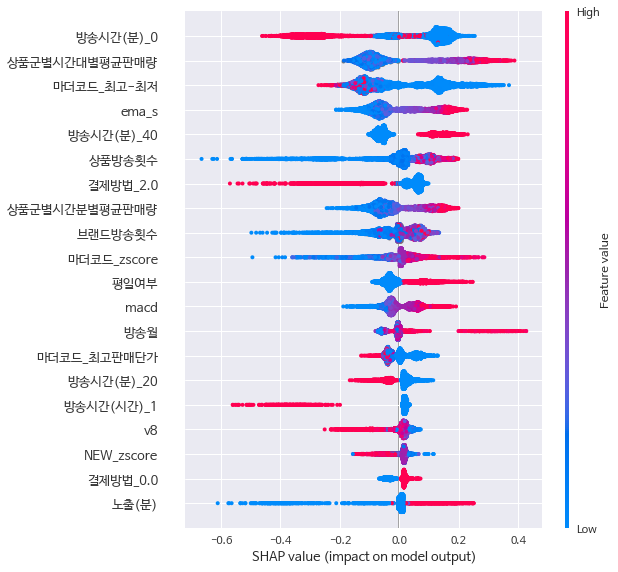

In [30]:
shap.summary_plot(shap_value, test)

### 2. Force Plot 
* 각각 관측값에 대해 feature들이 어떤 영향을 미치고 있는지 파악 가능 
* 빨간색 : 예측값을 더 **높게** 하는 변수들의 영향도 (SHAP values) 
* 파란색 : 예측값을 더 **낮게** 하는 변수들의 영향도 

In [34]:
shap.initjs()

# 첫번째 예측값 : visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(expected_value, shap_value[0,:], test.iloc[0,:])

In [35]:
shap.initjs()

# 101번째 test데이터의 예측값 : visualize the 101th prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(expected_value, shap_value[100,:], test.iloc[100,:])

In [41]:
shap.initjs()

# 1001번째 test데이터의 예측값 : visualize the 1001th prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(expected_value, shap_value[1000,:], test.iloc[1000,:])

In [43]:
shap.initjs()

# 5001번째 test데이터의 예측값 : visualize the 5001th prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(expected_value, shap_value[5000,:], test.iloc[5000,:])

In [51]:
shap.initjs()

# 전체 데이터셋... 근데 겁나 오래걸리고 코랩 스탑되면서 안나와...... visualize the training set predictions
shap.force_plot(expected_value, shap_value, test)

### 3. Dependency Plot 


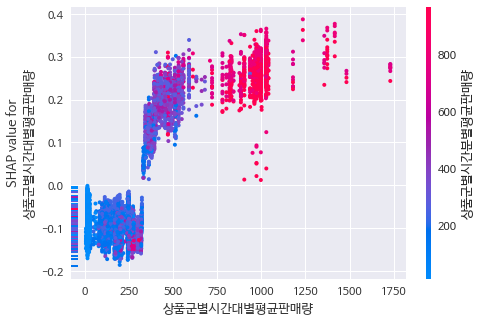

In [44]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("상품군별시간대별평균판매량", shap_value, test)

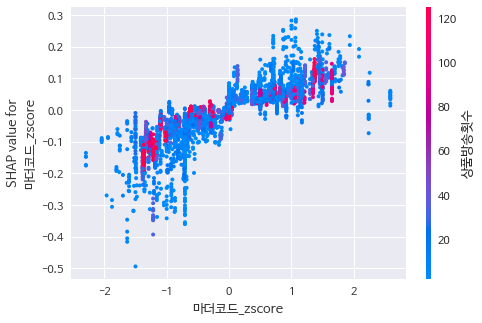

In [45]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("마더코드_zscore", shap_value, test)

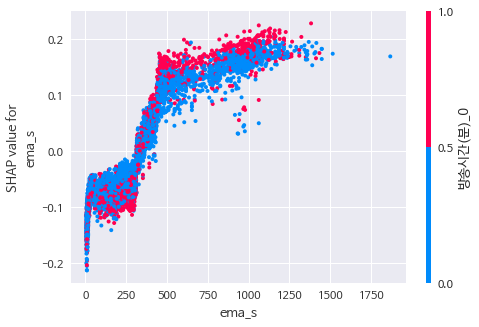

In [46]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("ema_s", shap_value, test)

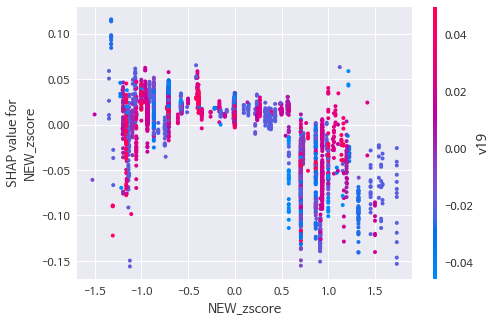

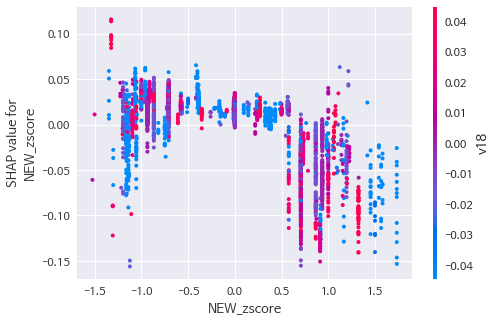

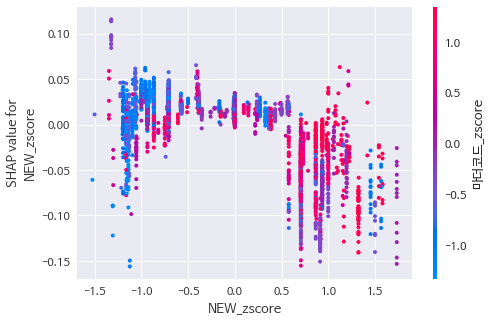

In [52]:
# we can use shap.approximate_interactions to guess which features
# may interact with age
inds = shap.approximate_interactions("NEW_zscore", shap_value, test)

# make plots colored by each of the top three possible interacting features
for i in range(3):
    shap.dependence_plot("NEW_zscore", shap_value, test, interaction_index=inds[i])

### 4. Decision Plot
* https://slundberg.github.io/shap/notebooks/plots/decision_plot.html 
* 이거 있어보이는데 쓸려면 subsampling+feature selection 해야됩니당 

In [49]:
shap.decision_plot(expected_value, shap_value, test.columns)

RuntimeError: ignored

In [39]:
final = {
    'lgbm_5th' : [lgbm_mape5, lgbm_pred5, lgbm_feat_imp5, lgbm_SHAP5]
}

In [40]:
with open("0915_pred.pkl", 'wb') as f:
    pkl.dump(final,f)